In [1]:
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt
from pandas import read_csv
import seaborn as sb
import warnings
warnings.filterwarnings('ignore')
from tqdm import tqdm_notebook as tqdm
from sklearn.cluster import KMeans
from sklearn.metrics import classification_report, confusion_matrix
from seaborn import scatterplot as scatter
from fcmeans import FCM #pip install fuzzy-c-means
from sklearn.model_selection import train_test_split

import seaborn as sns
from pylab import rcParams
rcParams['figure.figsize'] = 12, 6
sns.set(style='whitegrid', palette='muted', font_scale=1.5)

#### DADOS

2083
893


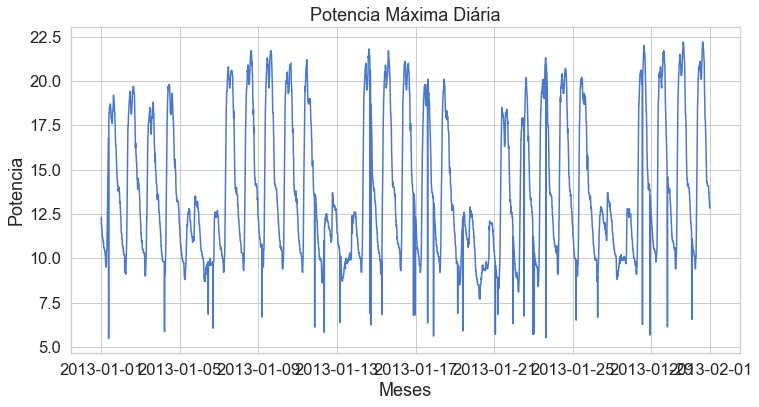

In [2]:
data_path = 'data_with_outliers_30_vales.pkl'

df2 = pd.read_pickle(data_path)
plt.title('Potencia Máxima Diária')
plt.xlabel('Meses')
plt.ylabel('Potencia')
plt.plot(df2.Potencia)

##SEPARA DADOS 30% teste 70% treino
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(df2.Potencia, df2.is_outlier, test_size=0.3,random_state=42, shuffle=False)

## FORMA DATAFRAMES TREINO E TESTE
dftreino=pd.DataFrame([X_train, y_train]).transpose()
dftreino.sort_index(inplace=True)
dfteste=pd.DataFrame([X_test, y_test]).transpose()
dfteste.sort_index(inplace=True)


##X = list(zip(X_train.values, X_train.values)) 

## PREPARANDO X, Y PARA PLOT 2D
P = np.array(dftreino.Potencia) 
F=np.concatenate((P, P), axis=0)
G=np.reshape(F, (2, -1))
X = np.transpose(G) #aqui temos as coordenadas Potencia x Potencia
print(len(X_train))
print(len(X_test))

#### Z-SCORE

In [3]:
def zscore_outlier(dftreino, threshold=3, plots=True, metrics=True):
    dftreino['z-score'] = None
    mean_1 = np.mean(dftreino.Potencia)
    std_1 =np.std(dftreino.Potencia)
    
    dftreino['zs_outlier'] = 'inlier'
    dftreino['label_zs'] = 0
    
    for y in range(0,len(dftreino.Potencia)):
        potencia = dftreino.Potencia.iloc[y]
        dftreino['z-score'].iloc[y] = (potencia - mean_1)/std_1 
        if np.abs(dftreino['z-score'].iloc[y]) > threshold:
            dftreino['zs_outlier'].iloc[y] = 'outlier'
            dftreino['label_zs'].iloc[y] = 1
    
    
    outliers = dftreino[dftreino['zs_outlier']=='outlier']
    
    if plots:
        ## PLOT CLUSTERIZACAO OUTLIERS
        plt.figure(figsize=(16,8))
        plt.plot(dftreino.index.values, dftreino.Potencia, outliers.index.values, outliers.Potencia,'r.')
        #plt.legend(loc='upper right')
        plt.legend(['Curva de demandad','ponto etiquetado como outlier','picos'],loc=0)
        plt.xlabel('Data')
        plt.ylabel('Potência(MW)')
        #plt.legend('Potencia','outliers')
        
        plt.grid('on')
        plt.savefig("ex_zscore_treino.pdf", bbox_inches = 'tight', pad_inches = 0)
    
    if metrics:
        from sklearn.metrics import confusion_matrix, matthews_corrcoef
        array = confusion_matrix(dftreino['zs_outlier'], dftreino.is_outlier)
        qtd_outlier = len(dftreino[dftreino.is_outlier=='outlier'])
        df_cm = pd.DataFrame(array, index = [i for i in ["inliner","outlier"]],
                      columns = [i for i in ["inliner","outlier"]])
        plt.figure(figsize = (8,4))
        ax = sb.heatmap(df_cm, annot=True,cmap="PiYG",fmt='d', cbar=False, vmax=qtd_outlier)
        ax.set(xlabel='Predito', ylabel='Real')
        plt.show()
    
    
    return dftreino


#### Z-SCORE MODIFICADO


In [4]:
def zscore_mod_outlier(dftreino, threshold=3.5, plots=True, metrics=True):
   
    dftreino['label_zsm'] = 0
    points = dftreino.Potencia
    if len(points.shape) == 1:
        points = points[:,None]
    median = np.median(points, axis=0)
    diff = np.sum((points - median)**2, axis=-1)
    diff = np.sqrt(diff.astype(np.float))
    med_abs_deviation = np.median(diff)

    dftreino['zscore_mod'] = 0
    zscoremod = (0.6745 * diff / med_abs_deviation) 
    dftreino['zscore_mod'] = zscoremod

    dftreino['zs_mod_outlier'] = 'inlier'
    for x in range(0,len(dftreino)):
        if np.abs(dftreino['zscore_mod'].iloc[x]) > threshold:
            dftreino['zs_mod_outlier'].iloc[x] = 'outlier'
            dftreino['label_zsm'].iloc[x] = 1
            
    outliers = dftreino[dftreino['zs_mod_outlier']=='outlier']
    
    if plots:
        ## PLOT CLUSTERIZACAO OUTLIERS
        plt.figure(figsize=(16,8))
        plt.plot(dftreino.index.values, dftreino.Potencia, outliers.index.values, outliers.Potencia,'r.')
        plt.legend(['Curva de demandad','ponto etiquetado como outlier','picos'],loc=0)
        plt.xlabel('Data')
        plt.ylabel('Potência(MW)')
        plt.grid('on')
        plt.savefig("ex_zscore_mod_treino.pdf", bbox_inches = 'tight', pad_inches = 0)
    
    if metrics:
        from sklearn.metrics import confusion_matrix, matthews_corrcoef
        array = confusion_matrix(dftreino['zs_mod_outlier'], dftreino.is_outlier)
        qtd_outlier = len(dftreino[dftreino.is_outlier=='outlier'])
        df_cm = pd.DataFrame(array, index = [i for i in ["inliner","outlier"]],
                      columns = [i for i in ["inliner","outlier"]])
        plt.figure(figsize = (8,4))
        ax = sb.heatmap(df_cm, annot=True,cmap="PiYG",fmt='d', cbar=False, vmax=qtd_outlier)
        ax.set(xlabel='Predito', ylabel='Real')
        plt.show()
    
    
    return dftreino


#### K-MEANS

In [5]:
def agrupador_kmeans(X,dftreino,k=7, plots=True, metrics=True):

    ### CLUSTERIZACAO KMEANS
    kmeans = KMeans(n_clusters=k, max_iter=1000000, random_state=0)
    kmeans.fit_transform(X)
    kmeans.labels_

    #centros dos clusters  [Centro  K-Classes]
    #Neste caso o Centro=0, fornece como classe=3
    #Portanto, deve filtrar posteriormente a classe 3 para extrair os outliers


    centroides=np.around(kmeans.cluster_centers_,decimals=2)
    #Pegando os labels(clusters) e colocando ao Dataframe df2
    dftreino['K-classes'] = kmeans.labels_

    dftreino['KM-distance'] = 0.0

    from sklearn.metrics.pairwise import euclidean_distances
    for x in range(0,len(dftreino)):

        ponto = [dftreino.Potencia.iloc[x],dftreino.Potencia.iloc[x]]
        centroide = kmeans.cluster_centers_[dftreino['K-classes'].iloc[x]]
        dftreino['KM-distance'].iloc[x] = euclidean_distances([ponto,centroide])[1][0]


    ## O LIMIAR É A MEDIA MAIS QUATRO VEZES O STD
    limiar = dftreino['KM-distance'].mean()+3*dftreino['KM-distance'].std()
    outliers = dftreino[dftreino['KM-distance']>limiar]


    dftreino['K-means'] = 'inlier'
    ## CRIANDO COLUNA COM OS OUTLIERS PREVISTOS
    dftreino['K-means'].loc[dftreino['KM-distance']>limiar] = 'outlier'

    if metrics:
        print(classification_report(dftreino['K-means'], dftreino.is_outlier))
        display(pd.crosstab(dftreino['K-means'],dftreino.is_outlier, rownames=['Real'], colnames=['Predito'], margins=True))


        from sklearn.metrics import confusion_matrix, matthews_corrcoef
        array = confusion_matrix(dftreino['K-means'], dftreino.is_outlier)
        qtd_outlier = len(dftreino[dftreino.is_outlier=='outlier'])
        df_cm = pd.DataFrame(array, index = [i for i in ["inliner","outlier"]],
                      columns = [i for i in ["inliner","outlier"]])
        plt.figure(figsize = (8,4))
        ax = sb.heatmap(df_cm, annot=True,cmap="PiYG",fmt='d', cbar=False, vmax=qtd_outlier)
        ax.set(xlabel='Predito', ylabel='Real')
        plt.show()
    
    
    if plots:
        # plot result
        %matplotlib inline
        f, axes = plt.subplots(1, 2, figsize=(11,5))
        scatter(X[:,0], X[:,1], ax=axes[0])
        scatter(X[:,0], X[:,1], ax=axes[1], hue=dftreino['K-classes'])
        scatter(centroides[:,0], centroides[:,1], ax=axes[1],marker="s",s=200)
        plt.show()


        ### SCATTER PLOT COLORIDO DE ACORDO COM OS AGRUPAMENTOS
        plt.figure(figsize=(16,8))
        plt.grid('on')
        import matplotlib.cm as cm
        colors = cm.tab10(dftreino['K-classes'].values/7)
        plt.scatter(range(0,len(X)), X[:, 1], marker='.', s=200, lw=0, alpha=0.7,
                    c=colors, edgecolor='k')
        # Labeling the clusters
        centers = centroides
        # Draw white circles at cluster centers
        plt.scatter([len(dftreino)/2] * len(centroides),centers[:, 0], marker='o',
                    c="white", alpha=1, s=200, edgecolor='k')

        for i, c in enumerate(centers):
            plt.scatter(len(dftreino)/2, c[1], marker='$%d$' % i, alpha=1,
                        s=50, edgecolor='k')

        #plt.set_title("The visualization of the clustered data.")
        plt.ylabel('Potência (MW)')
        plt.xlabel('Dados')
        plt.title('Clusters K-means')
        plt.savefig("ex_cluster_km.pdf", bbox_inches = 'tight', pad_inches = 0)
        plt.plot()


        dfplot = pd.DataFrame()
        dfplot['Potencia'] = dftreino.Potencia
        dfplot['K-classes'] = dftreino['K-classes']
        g = sb.pairplot(dfplot,hue='K-classes')
        g.fig.set_size_inches(6,4)

        ## PLOT CLUSTERIZACAO OUTLIERS
        plt.figure(figsize=(16,8))
        plt.plot (dftreino.index.values, dftreino.Potencia,outliers.index.values, outliers.Potencia,'r.')
        plt.legend(['Curva de demanda','ponto etiquetado como outlier','picos'])
        plt.xlabel('Data')
        plt.ylabel('Potência(MW)')
        plt.grid('on')
        plt.savefig("ex_kmeans_treino.pdf", bbox_inches = 'tight', pad_inches = 0)
    
    
    return dftreino

#### C-MEANS

In [6]:
def agrupador_cmeans(X,dftreino,k=7, m=2,plots=True, metrics=True):
    # fit the fuzzy-c-means
    fcm = FCM(n_clusters=k, m=m)
    fcm.fit(X)

    # outputs
    fcm_centers = fcm.centers
    fcm_labels  = fcm.u.argmax(axis=1)

    from sklearn.metrics.pairwise import euclidean_distances
    ## SEPARANDO OS CLUSTERS EXTREMOS
    Classe_Zero = np.argmin(fcm_centers,axis=0)[0]
    Classe_Picos = np.argmax(fcm_centers, axis=0)[0]
    dftreino['C-classes'] = None
    dftreino['E-distance'] = None
    
    ## CRIANDO A COLUNA C-CLASSES PARA POR O LABEL(CLUSTER) A QUAL O DADO PERTENCE
    ## COLUNA E-distance para por a distancia euclidiana(nosso dado 
    ## é univariado entao só tem 1 coordenada) do dado a sua centroide
    for x in range(0,len(dftreino)):
        dftreino['C-classes'].iloc[x] = np.where(fcm.u[x] == max(fcm.u[x]))[0][0]
        ponto = [dftreino.Potencia.iloc[x],dftreino.Potencia.iloc[x]]
        centroide = fcm_centers[dftreino['C-classes'].iloc[x]]
        dftreino['E-distance'].iloc[x] = euclidean_distances([ponto,centroide])[1][0]

    ## O LIMIAR É A MEDIA MAIS QUATRO VEZES O STD
    limiar = dftreino['E-distance'].mean()+3*dftreino['E-distance'].std()
    outliers = dftreino[dftreino['E-distance']>limiar]    
    

    #Filtrando Elementos com a classe que contem os ZEROS ou PROXIMOS DO ZERO
    outliersZeros = dftreino[(dftreino['C-classes']==Classe_Zero) & (dftreino['E-distance']>limiar)]
    #Filtrando Elementos com a classe que contem os PICOS POSITIVOS
    outliersPicos = dftreino[(dftreino['C-classes']==Classe_Picos) & (dftreino['E-distance']>limiar)]

    dftreino['C-means'] = 'inlier'
    for x in range(0,len(dftreino)):
        if (((dftreino['C-classes'].iloc[x]==Classe_Zero) & (dftreino['E-distance'].iloc[x]>limiar)) | ((dftreino['C-classes'].iloc[x]==Classe_Picos) & (dftreino['E-distance'].iloc[x]>limiar))):
            dftreino['C-means'].iloc[x] = 'outlier'

    if metrics:
        print(classification_report(dftreino['C-means'], dftreino.is_outlier))
        conf_matrix = pd.crosstab(dftreino['C-means'],dftreino.is_outlier, rownames=['Real'], colnames=['Predito'], margins=True)
        display(conf_matrix)


        from sklearn.metrics import confusion_matrix, matthews_corrcoef
        array = confusion_matrix(dftreino['C-means'], dftreino.is_outlier)
        qtd_outlier = len(dftreino[dftreino.is_outlier=='outlier'])
        df_cm = pd.DataFrame(array, index = [i for i in ["inliner","outlier"]],
                      columns = [i for i in ["inliner","outlier"]])
        plt.figure(figsize = (8,4))
        ax = sb.heatmap(df_cm, annot=True,cmap="PiYG",fmt='d', cbar=False, vmax=qtd_outlier)
        ax.set(xlabel='Predito', ylabel='Real')
        #plt.savefig("ex_cm.pdf")
        plt.show()
    
    if plots:
        # plot result
        %matplotlib inline
        f, axes = plt.subplots(1, 2, figsize=(11,5))
        scatter(X[:,0], X[:,1], ax=axes[0])
        scatter(X[:,0], X[:,1], ax=axes[1], hue=fcm_labels)
        scatter(fcm_centers[:,0], fcm_centers[:,1], ax=axes[1],marker="s",s=200)
        plt.show()

        ### SCATTER PLOT COLORIDO DE ACORDO COM OS AGRUPAMENTOS
        plt.figure(figsize=(16,8))
        plt.grid('on')
        import matplotlib.cm as cm
        colors = cm.tab10(dftreino['C-classes'].values.astype(float)/7)
        plt.scatter(range(0,len(X)), X[:, 1], marker='.', s=200, lw=0, alpha=0.7,
                    c=colors, edgecolor='k')
        # Labeling the clusters
        centers = fcm_centers
        # Draw white circles at cluster centers
        plt.scatter([len(dftreino)/2] * len(fcm_centers),centers[:, 0], marker='o',
                    c="white", alpha=1, s=200, edgecolor='k')

        for i, c in enumerate(centers):
            plt.scatter(len(dftreino)/2, c[1], marker='$%d$' % i, alpha=1,
                        s=50, edgecolor='k')

        #plt.set_title("The visualization of the clustered data.")
        plt.ylabel('Potência(MW)')
        plt.xlabel('Dados')
        plt.title('Clusters C-means')
        plt.savefig("ex_cluster_cm.pdf", bbox_inches = 'tight', pad_inches = 0)
        plt.plot()


        plt.figure(figsize=(16,8))
        plt.plot (dftreino.index.values, dftreino.Potencia,outliers.index.values, outliers.Potencia,'r.')
        plt.legend(['Curva de demanda','ponto etiquetado como outlier'])
        plt.xlabel('Data')
        plt.ylabel('Potência(MW)')
        plt.grid('on')
        plt.savefig("ex_cmeans_treino.pdf", bbox_inches = 'tight', pad_inches = 0)


    
    
    return dftreino

#### KNN

In [7]:
import pandas as pd
import numpy as np
from scipy import stats
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

def classificador_knn(dftreino, dfteste,sigla='km',sigla2='K-means', k=5, otimizaK=True):

    ##CRIA COLUNA PARA TRANSFORMAR OS OUTLIERS PREVISTOS EM 0 ou 1
    dftreino
    label = f'label_{sigla}'
    dftreino[label] = 0.0
    for x in range(0,len(dftreino)):
        if dftreino[sigla2].iloc[x] == 'inlier':
            dftreino[label].iloc[x] = 0
        else:
            dftreino[label].iloc[x] = 1

    ##CRIA COLUNA PARA TRANSFORMAR OS OUTLIERS REAIS DO CONJUNTO DE TESTES EM 0 ou 1        
    dfteste[label] = 0.0
    for x in range(0,len(dfteste)):
        if dfteste['is_outlier'].iloc[x] == 'inlier':
            dfteste[label].iloc[x] = 0
        else:
            dfteste[label].iloc[x] = 1

            
    Xtreinar=list(zip(X_train.values, X_train.values))
    ytreinar=dftreino[label].values
    Xtestar=list(zip(X_test.values, X_test.values))
    ytestar=dfteste[label].values        
            
            
    if otimizaK:

        #import metrics model to check the accuracy 
        from sklearn import metrics
        #Try running from k=1 through 25 and record testing accuracy
        k_range = range(1,26)
        scores = {}
        scores_list = []
        k=1
        for x in k_range:
                knn = KNeighborsClassifier(n_neighbors=x)
                knn.fit(Xtreinar,ytreinar)
                y_pred=knn.predict(Xtestar)
                scores[x] = metrics.accuracy_score(ytestar,y_pred)
                if scores[x] >= scores[k]: k=x
                scores_list.append(metrics.accuracy_score(ytestar,y_pred))
    print(f'Utilizando k={k}')
            
            
    #AGORA VAMOS VER
    #import the KNeighborsClassifier class from sklearn
    from sklearn.neighbors import KNeighborsClassifier
    knn = KNeighborsClassifier(n_neighbors=k)
    knn.fit(Xtreinar,ytreinar)

    #Making prediction on some unseen data 
    #predict for the below two random observations

    y_predict = knn.predict(Xtestar)

    label2 = f'knn_{sigla}'
    dfteste[label2]=pd.Series(y_predict).values
    knn_pred = dfteste[dfteste[label2]==1]

    # visualize the results
    #visualize(clf_name, list(zip(X_train.values, X_train.values)), dftreino.label_cm.values, list(zip(X_test.values, X_test.values)), dfteste.label_cm.values, y_train_pred, y_test_pred, show_figure=True, save_figure=True)
    
    label2 = f'knn_{sigla}'
    dfteste[label2]=pd.Series(y_predict).values
    knn_pred = dfteste[dfteste[label2]==1]

    ##PLOT RESULTADOS PREVISTOS
    plt.figure(figsize=(16,8))
    plt.plot (X_test.index.values, X_test.values,knn_pred.index.values, knn_pred.Potencia.values,'r.')
    plt.legend(['Curva de demanda','Ponto identificado como outlier'])
    plt.xlabel('Data')
    plt.ylabel('Potência (MW)')
    #plt.legend(loc='upper left')
    plt.grid('on')
    plt.savefig(f'knn_{sigla}.pdf', bbox_inches = 'tight', pad_inches = 0)
    plt.show()

    ##MATRIZ DE CONFUSAO
    confusion_matrix = pd.crosstab(dfteste[label2],dfteste[label], rownames=['Real'], colnames=['Previsto'],  margins=True)
    print(classification_report(dfteste[label2], dfteste[label]))
    display(confusion_matrix)
    
    
    from sklearn.metrics import confusion_matrix, matthews_corrcoef
    print(f'MCC = {matthews_corrcoef(dfteste[label2], dfteste[label])}')
    array = confusion_matrix(dfteste[label2], dfteste[label])
    qtd_outlier = len(dfteste[dfteste.is_outlier=='outlier'])
    df_cm = pd.DataFrame(array, index = [i for i in ["inliner","outlier"]],
                  columns = [i for i in ["inliner","outlier"]])
    plt.figure(figsize = (8,4))
    ax = sb.heatmap(df_cm, annot=True,cmap="PiYG",fmt='d', cbar=False, vmax=qtd_outlier)
    ax.set(xlabel='Predito', ylabel='Real')
    plt.savefig(f"cm_{sigla}.pdf", bbox_inches = 'tight', pad_inches = 0)
    plt.show()

#### INTERPOLACAO LINEAR

In [8]:
def zera_e_corrige(dfteste, sigla): 
    
    #Colocando todos os outliers para zeros
    dfteste['Potencia_corrigida'] = dfteste.Potencia
    label = f'knn_{sigla}'
    dfteste.Potencia_corrigida[dfteste[label]==1] = np.nan
    
    #aplicar a interpolação
    dfteste.Potencia_corrigida=dfteste.Potencia_corrigida.astype(float).interpolate(method='linear', limit_direction='forward', axis=0)
    plt.figure(figsize=(16,8))
    plt.plot (dfteste.index.values, dfteste.Potencia_corrigida)
    plt.legend(['Curva de demanda'])
    plt.xlabel('Data')
    plt.ylabel('Potência (MW)')
    plt.grid('on')
    plt.savefig(f'corrigido_{sigla}.pdf', bbox_inches = 'tight', pad_inches = 0)

#### CALC ERRO COM CURVA SEM OUTLIERS

In [9]:
def calc_erro(dfteste):
    
    dfsemoutliers = pd.read_pickle('E:\Dropbox\PIBIC Ricado 2019\TCC Ricardo 2020-1\codigo\dados janeiro 2013\data_without_outliers.pkl')
    dfsemoutliers.set_index('Data', inplace=True)

    ##SEPARA DADOS 30% teste 70% treino
    from sklearn.model_selection import train_test_split
    X_train, X_test = train_test_split(dfsemoutliers.Potencia, test_size=0.3,random_state=42, shuffle=False)
    
    from sklearn.metrics import mean_absolute_error, mean_squared_error
    print(f'MAE: {mean_absolute_error(X_test.values, dfteste.Potencia_corrigida.values)}')
    print(f'MSE: {mean_squared_error(X_test.values, dfteste.Potencia_corrigida.values)}')
    
    def mean_absolute_percentage_error(y_true, y_pred): 
        y_true, y_pred = np.array(y_true), np.array(y_pred)
        return np.mean(np.abs((y_true - y_pred) / y_true)) * 100
    
    print(f'MAPE: {round(mean_absolute_percentage_error(X_test.values, dfteste.Potencia_corrigida.values),2)}%')

# RESULTADOS:

#### K-MEANS

In [10]:
dftreino = agrupador_kmeans(X,dftreino,3, False, False)

Utilizando k=5


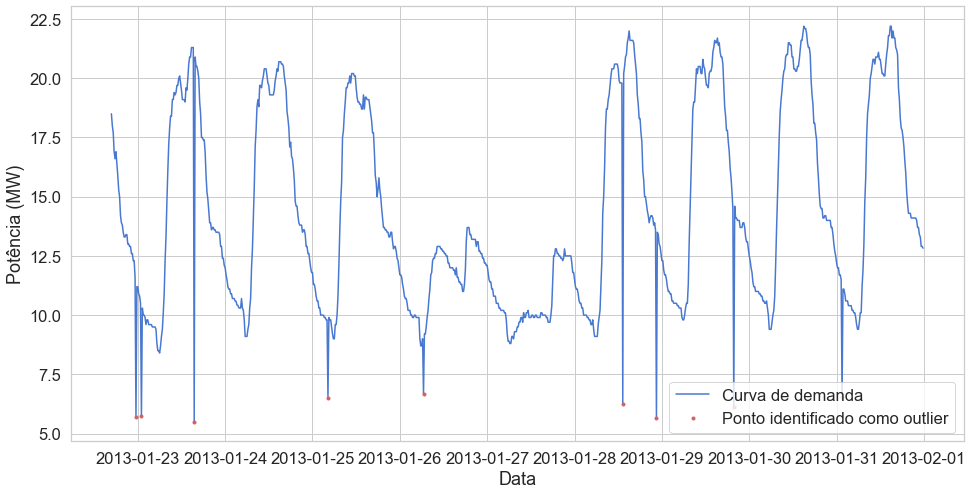

              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00       884
         1.0       1.00      1.00      1.00         9

    accuracy                           1.00       893
   macro avg       1.00      1.00      1.00       893
weighted avg       1.00      1.00      1.00       893



Previsto,0.0,1.0,All
Real,,,
0.0,884,0,884
1.0,0,9,9
All,884,9,893


MCC = 1.0


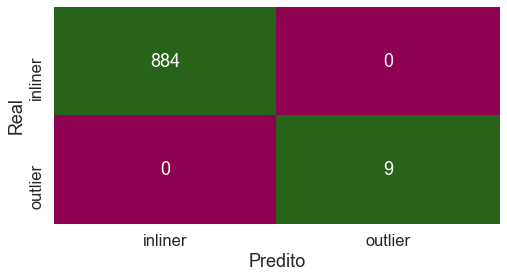

In [11]:
classificador_knn(dftreino, dfteste, 'km', 'K-means', 5, False)

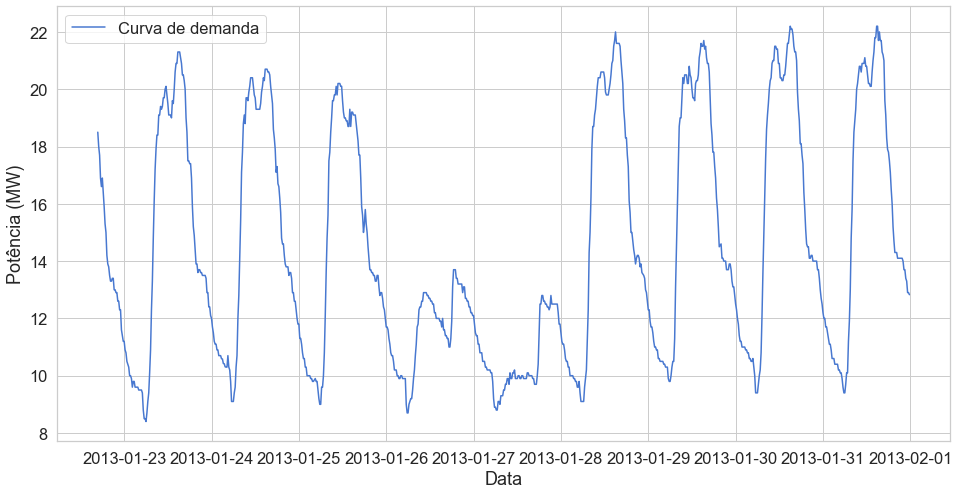

In [12]:
zera_e_corrige(dfteste, 'km')

In [13]:
calc_erro(dfteste)

MAE: 0.001175814219578395
MSE: 0.00017637232516932034
MAPE: 0.01%


#### C-MEANS

              precision    recall  f1-score   support

      inlier       1.00      1.00      1.00      2062
     outlier       1.00      1.00      1.00        21

    accuracy                           1.00      2083
   macro avg       1.00      1.00      1.00      2083
weighted avg       1.00      1.00      1.00      2083



Predito,inlier,outlier,All
Real,,,
inlier,2062,0,2062
outlier,0,21,21
All,2062,21,2083


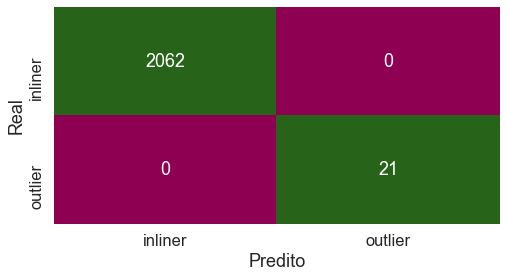

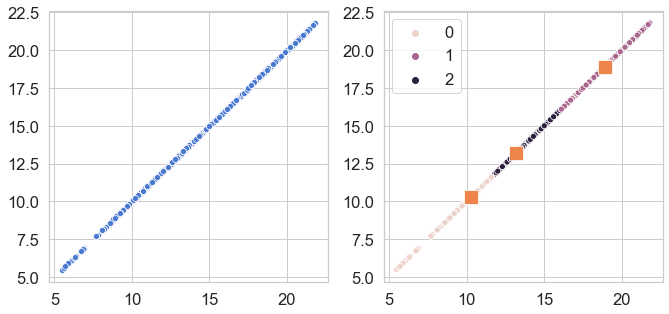

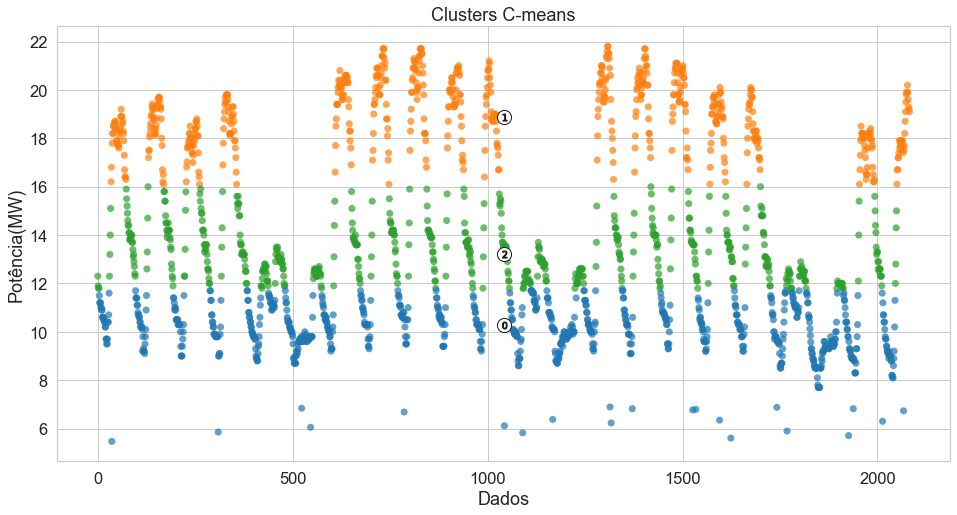

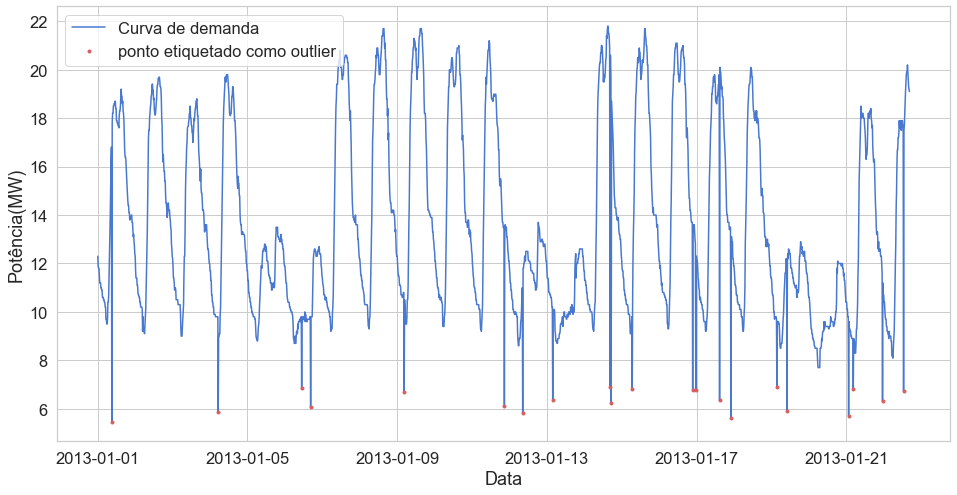

In [14]:
dftreino = agrupador_cmeans(X,dftreino,k=3, m=50, plots=True, metrics=True)

Utilizando k=5


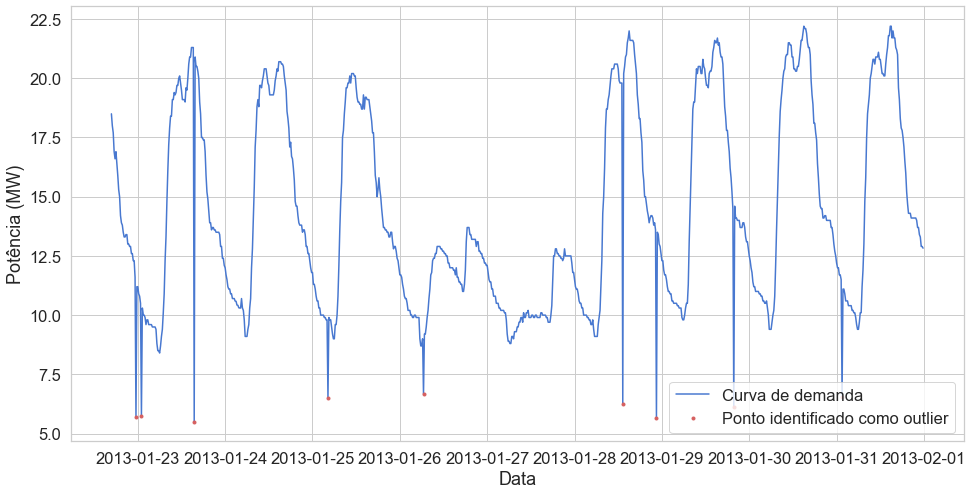

              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00       884
         1.0       1.00      1.00      1.00         9

    accuracy                           1.00       893
   macro avg       1.00      1.00      1.00       893
weighted avg       1.00      1.00      1.00       893



Previsto,0.0,1.0,All
Real,,,
0.0,884,0,884
1.0,0,9,9
All,884,9,893


MCC = 1.0


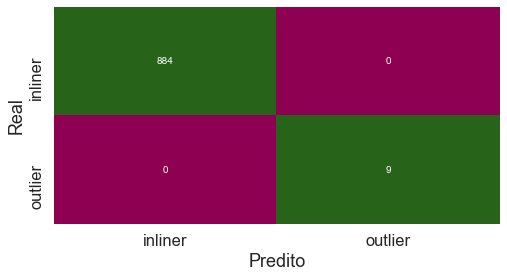

In [15]:
classificador_knn(dftreino, dfteste, 'cm', 'C-means', 5, False)

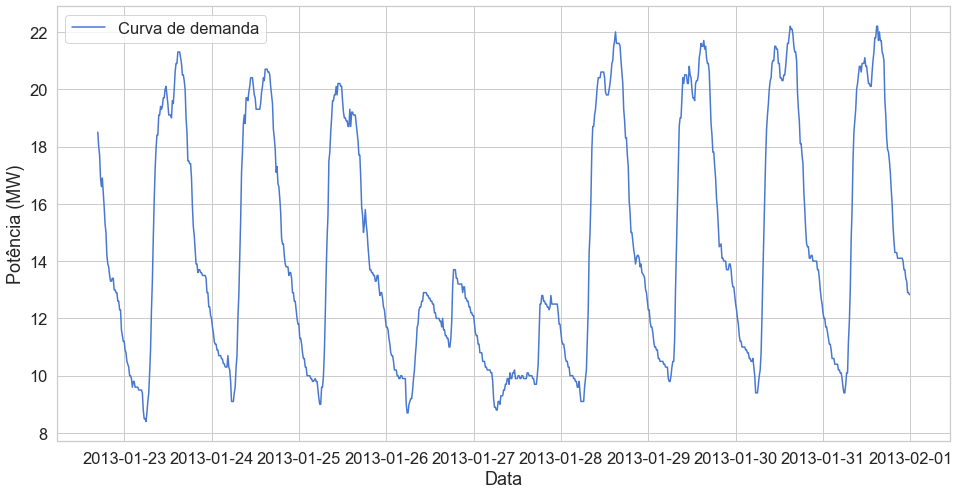

In [16]:
zera_e_corrige(dfteste, 'cm')

In [17]:
calc_erro(dfteste)

MAE: 0.001175814219578395
MSE: 0.00017637232516932034
MAPE: 0.01%


#### ZSCORE

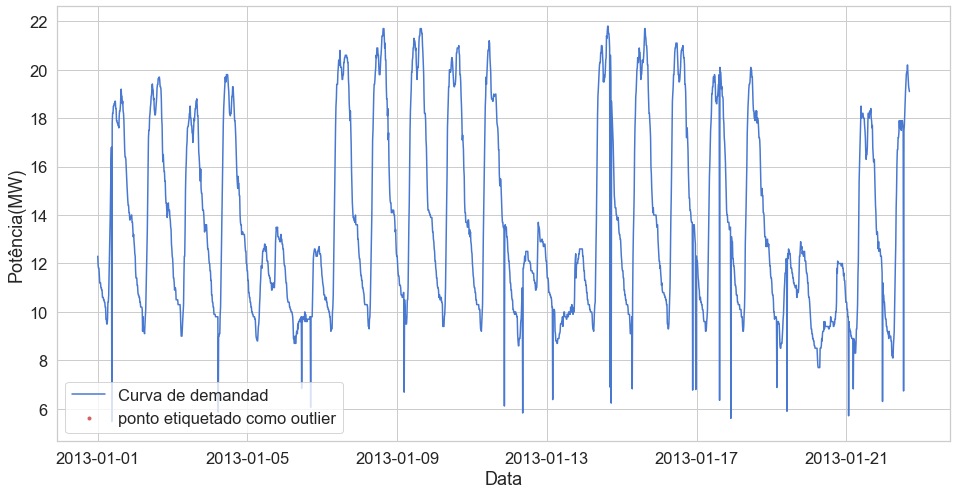

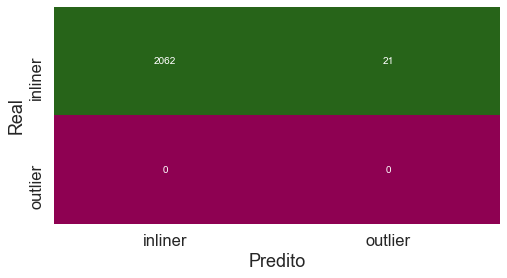

In [18]:
dftreino = zscore_outlier(dftreino, threshold=3, plots=True, metrics=True)

Utilizando k=5


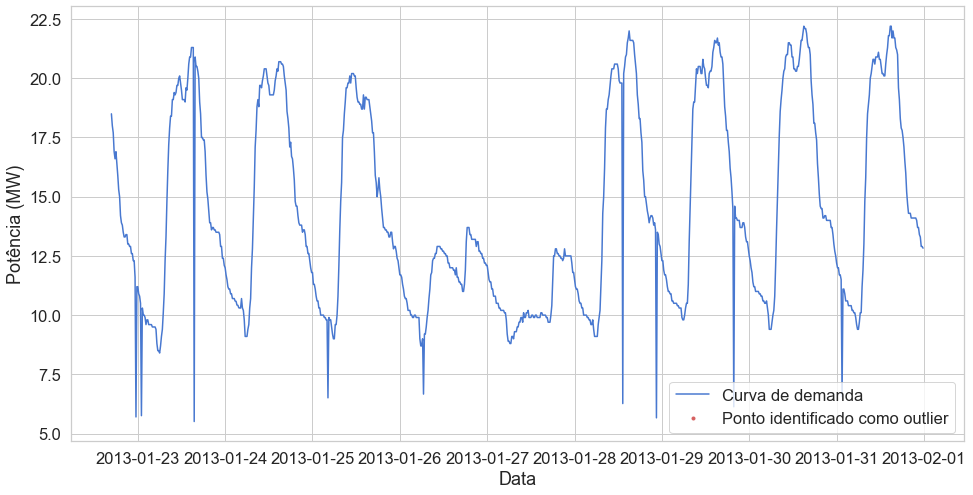

              precision    recall  f1-score   support

         0.0       1.00      0.99      0.99       893
         1.0       0.00      0.00      0.00         0

    accuracy                           0.99       893
   macro avg       0.50      0.49      0.50       893
weighted avg       1.00      0.99      0.99       893



Previsto,0.0,1.0,All
Real,,,
0.0,884,9,893
All,884,9,893


MCC = 0.0


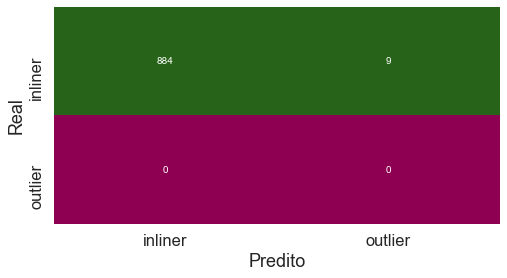

In [19]:
classificador_knn(dftreino, dfteste, 'zs', 'zs_outlier', 5, False)

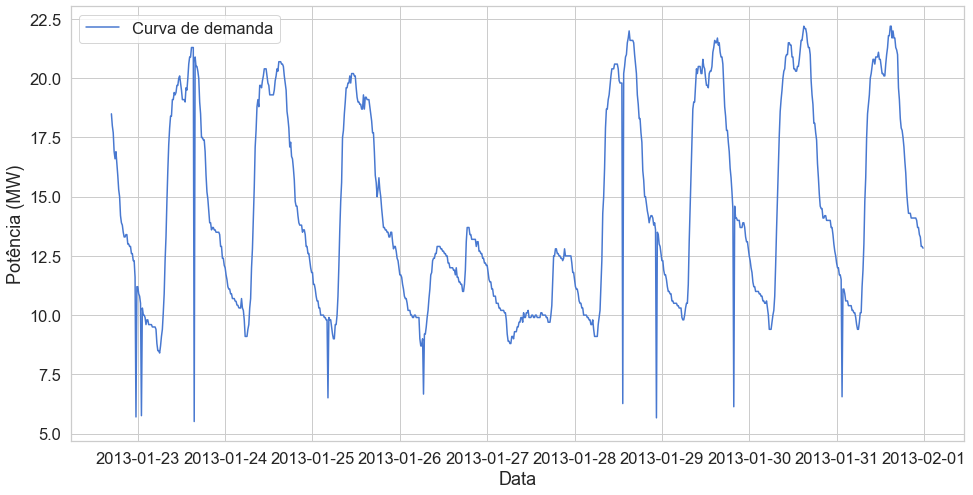

In [20]:
zera_e_corrige(dfteste, 'zs')

In [21]:
calc_erro(dfteste)

MAE: 0.0746383844630126
MSE: 0.7410373736984289
MAPE: 0.51%


#### ZSCORE MODIFICADO

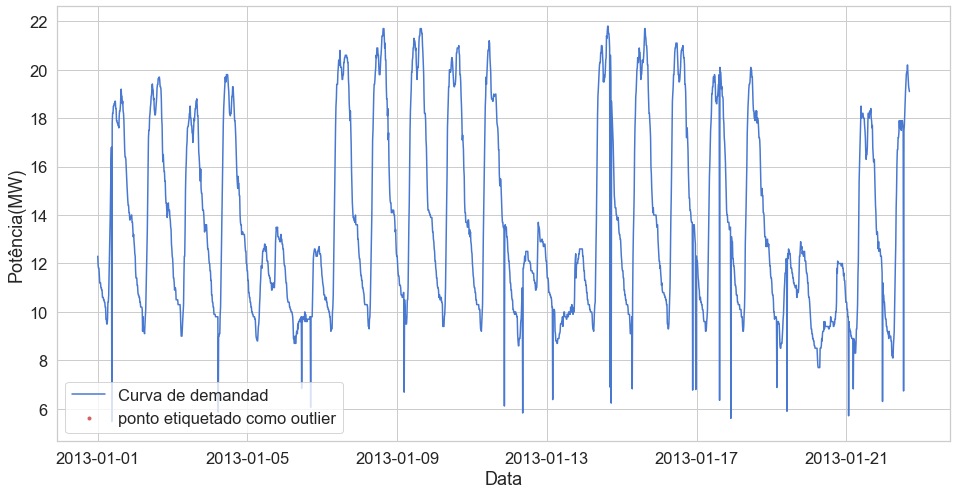

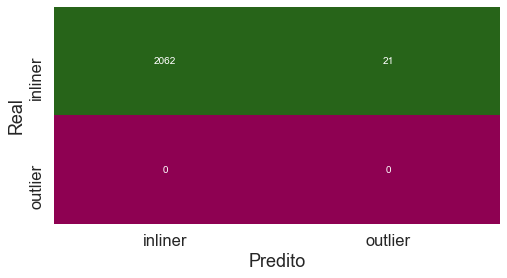

In [22]:
dftreino = zscore_mod_outlier(dftreino, threshold=3, plots=True, metrics=True)

Utilizando k=5


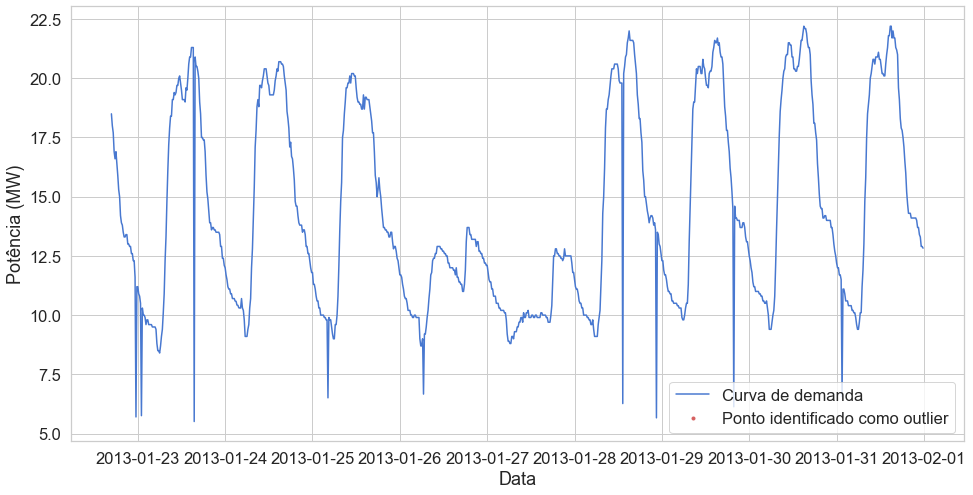

              precision    recall  f1-score   support

         0.0       1.00      0.99      0.99       893
         1.0       0.00      0.00      0.00         0

    accuracy                           0.99       893
   macro avg       0.50      0.49      0.50       893
weighted avg       1.00      0.99      0.99       893



Previsto,0.0,1.0,All
Real,,,
0.0,884,9,893
All,884,9,893


MCC = 0.0


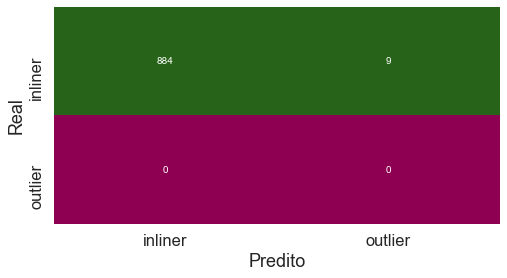

In [23]:
classificador_knn(dftreino, dfteste, 'zsm', 'zs_mod_outlier', 5, False)

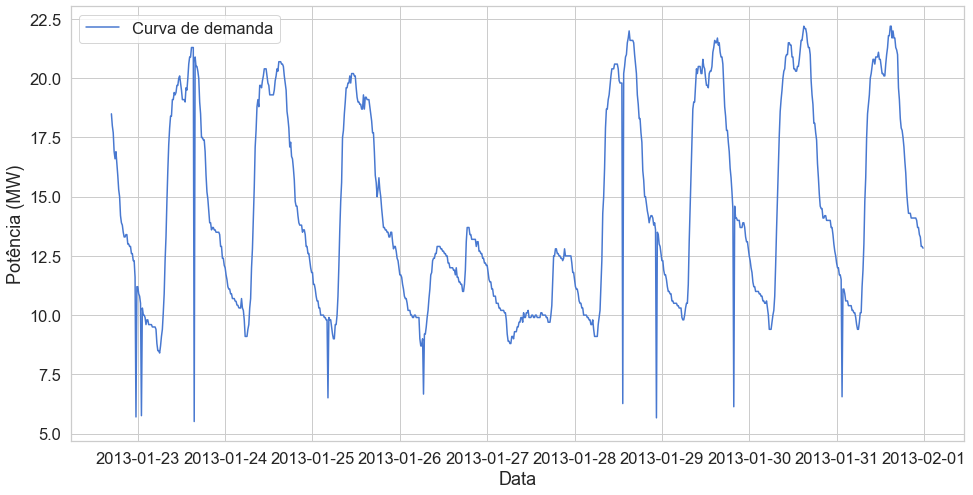

In [24]:
zera_e_corrige(dfteste, 'zsm')

In [25]:
calc_erro(dfteste)

MAE: 0.0746383844630126
MSE: 0.7410373736984289
MAPE: 0.51%


#### AUTOENCODER

In [26]:
def prepare_data(data, scaling = True,  differencing = False):
    
    ## PREPARANDO X, Y PARA PLOT 2D
    if differencing:
        P = np.array(data.diff()) 
        P[0]=0
    else:
        P = np.array(data) 

    F=np.concatenate((P, P), axis=0)
    G=np.reshape(F, (2, -1))
    X = np.transpose(G) # aqui temos as coordenadas Potencia x Potencia
    X = np.around(X, decimals=2) # 1 casa depois da virgula
    data = X[:,0]

    if scaling:
        from sklearn.preprocessing import StandardScaler, MinMaxScaler
        scaler = MinMaxScaler()
        data = scaler.fit_transform(X)[:,0]
    
    return data, scaler


def chunk_features(data, qtt=4):
    chunked = [data.values[i:i + 4] for i in range(0, len(data), 4)]
    return chunked



#%load_ext tensorboard
#import tensorflow as tf

def creating_autoencoder_model(input_dim=4, 
                               encoding_dim = 2, 
                               hidden_dim = 1, 
                               nb_epoch = 50, 
                               batch_size = 1, 
                               learning_rate = 0.1):

    from keras.models import Model, load_model
    from keras.layers import Input, Dense, Dropout, LSTM
    from keras import regularizers

    ## CRIANDO O MODELO
    input_layer = Input(shape=(input_dim, ))

    encoder = Dense(encoding_dim, activation="relu")(input_layer)
    decoder = Dense(input_dim, activation='tanh')(encoder)

    autoencoder = Model(inputs=input_layer, outputs=decoder)
    
    return autoencoder


def training_model(autoencoder, nb_epoch, batch_size, X_train, X_test):
    
    from keras.callbacks import ModelCheckpoint, TensorBoard
    ## COMPILANDO O MODELO
    autoencoder.compile(optimizer='adam', 
                        loss='mse', 
                        metrics=['accuracy'])

    checkpointer = ModelCheckpoint(filepath="model_seqs2.h5",
                                   verbose=0,
                                   save_best_only=True)
    
    
    #!rm -rf ./logs/
    #log_dir = "logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
    #tensorboard = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)


    history = autoencoder.fit(pd.DataFrame(X_train), pd.DataFrame(X_train),
                        epochs=nb_epoch,
                        batch_size=batch_size,
                        shuffle=True,
                        validation_data=(pd.DataFrame(X_test), pd.DataFrame(X_test)),
                        verbose=1,
                        callbacks=[checkpointer]).history
    plt.plot(history['loss'])
    plt.plot(history['val_loss'])

    plt.ylabel('loss')
    plt.xlabel('epochs')
    plt.legend(['treino', 'teste'], loc='upper right');
    plt.savefig("ex_erro_autoencoder.pdf", bbox_inches = 'tight', pad_inches = 0)
    
    return autoencoder




Using TensorFlow backend.








Train on 520 samples, validate on 224 samples
Epoch 1/50
520/520 [==============================] - 1s 2ms/step - loss: 0.1872 - acc: 0.2000 - val_loss: 0.0554 - val_acc: 0.2812
Epoch 2/50
520/520 [==============================] - 1s 2ms/step - loss: 0.0353 - acc: 0.2346 - val_loss: 0.0229 - val_acc: 0.2009
Epoch 3/50
520/520 [==============================] - 1s 2ms/step - loss: 0.0190 - acc: 0.1385 - val_loss: 0.0154 - val_acc: 0.1027
Epoch 4/50
520/520 [==============================] - 1s 2ms/step - loss: 0.0120 - acc: 0.1212 - val_loss: 0.0095 - val_acc: 0.1027
Epoch 5/50
520/520 [==============================] - 1s 2ms/step - loss: 0.0068 - acc: 0.1308 - val_loss: 0.0056 - val_acc: 0.1473
Epoch 6/50
520/520 [==============================] - 1s 2ms/step - loss: 0.0041 - acc: 0.1558 - val_loss: 0.0039 - val_acc: 0.2277
Epoch 7/50
520/520 [==============================] - 1s 2ms/step - loss: 0.0030 - acc: 0.2769 - val_loss: 0.0034 - val_acc: 0.3839
Epoch 8/50
520/520 [====

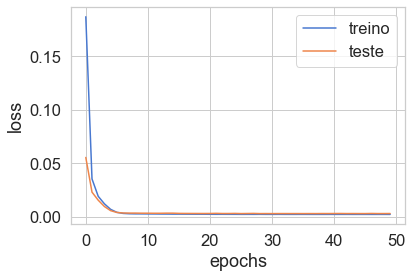

In [27]:
df2['Potencia_normalizada'], scaler = prepare_data(df2.Potencia, True, False)

### AQUI DIVIDIMOS OS DADOS PARA 4 ENTRADAS (Xn,Xn+1,Xn+2,Xn+3)
four_ents = chunk_features(df2.Potencia_normalizada, 4)


## SEPARANDO PARTE DOS DADOS PARA TREINAMENTO E VALIDAÇÃO
from sklearn.model_selection import train_test_split
X_train, X_test = train_test_split(four_ents, test_size=0.3,random_state=42)


input_dim=4
encoding_dim = 2
hidden_dim = 2
nb_epoch = 50
batch_size = 1
learning_rate = 0.01

autoencoder = creating_autoencoder_model(input_dim, encoding_dim, 
                                       hidden_dim, 
                                       nb_epoch, 
                                       batch_size, 
                                       learning_rate)

autoencoder = training_model(autoencoder, nb_epoch, batch_size, X_train, X_test)



##df2 = pd.read_pickle('data_with_outliers.pkl')
P = np.array(df2.Potencia) #.diff()
P[0]=0
F=np.concatenate((P, P), axis=0)
G=np.reshape(F, (2, -1))
X = np.transpose(G) #aqui temos as coordenadas Potencia x Potencia
X = np.around(X, decimals=2) #1 casa depois da virgula
scaled_data = scaler.fit_transform(X)[:,0]
### AQUI DIVIDIMOS OS DADOS PARA 4 ENTRADAS (Xn,Xn+1,Xn+2,Xn+3)
four_ents = [scaled_data[i:i + 4] for i in range(0, len(scaled_data), 4)]


#predict it
predicted = autoencoder.predict(pd.DataFrame(four_ents))
#get the error term
menos = np.concatenate(predicted) - np.concatenate(four_ents)
mse = np.mean(np.power(pd.DataFrame(menos), 2), axis=1)
#now add them to our data frame
df2['MSE'] = mse.values

In [28]:
dfteste_autoencoder = df2.tail(len(X_test)*4)
P = np.array(dfteste_autoencoder.Potencia) #.diff()
P[0]=0
F=np.concatenate((P, P), axis=0)
G=np.reshape(F, (2, -1))
X = np.transpose(G) #aqui temos as coordenadas Potencia x Potencia
X = np.around(X, decimals=2) #1 casa depois da virgula
scaled_data = scaler.fit_transform(X)[:,0]
### AQUI DIVIDIMOS OS DADOS PARA 4 ENTRADAS (Xn,Xn+1,Xn+2,Xn+3)
four_ents = [scaled_data[i:i + 4] for i in range(0, len(scaled_data), 4)]



#predict it
predicted = autoencoder.predict(pd.DataFrame(four_ents))
#get the error term
menos = np.concatenate(predicted) - np.concatenate(four_ents)
mse = np.mean(np.power(pd.DataFrame(menos), 2), axis=1)
#now add them to our data frame
dfteste_autoencoder['MSE'] = mse.values

#mse_threshold = 0.02
#mse_threshold = np.quantile(dfteste_autoencoder['MSE'], 0.987)
from scipy import stats
mse_threshold = stats.trim_mean(dfteste_autoencoder.MSE,0.01)*5
print(f'threshold = {mse_threshold}')
dfteste_autoencoder['MSE_Outlier'] = 0
dfteste_autoencoder.loc[(dfteste_autoencoder['MSE'] > mse_threshold, 'MSE_Outlier')] = 1
dfteste_autoencoder.MSE_Outlier.iloc[[0,1,2,3]] = 0



outliers = dfteste_autoencoder[dfteste_autoencoder.MSE_Outlier==1]
### OS 4 primeiros não são avaliados

threshold = 0.012382594957431929


In [29]:
outliers

,Potencia,is_outlier,Potencia_normalizada,MSE,MSE_Outlier
Data,,,,,
2013-01-22 23:00:00,12.300000,inlier,0.408249,0.017166,1
2013-01-23 15:15:00,21.299999,inlier,0.946204,0.013879,1
2013-01-23 15:30:00,5.507175,outlier,0.002391,0.030944,1
2013-01-23 15:45:00,20.900000,inlier,0.922295,0.048152,1
2013-01-25 04:15:00,6.507732,outlier,0.062164,0.017051,1
2013-01-28 13:00:00,19.799999,inlier,0.856545,0.028550,1
2013-01-28 13:15:00,6.265303,outlier,0.047818,0.231362,1
2013-01-28 13:45:00,20.500000,inlier,0.898386,0.019685,1
2013-01-28 22:00:00,13.900000,inlier,0.503885,0.021070,1


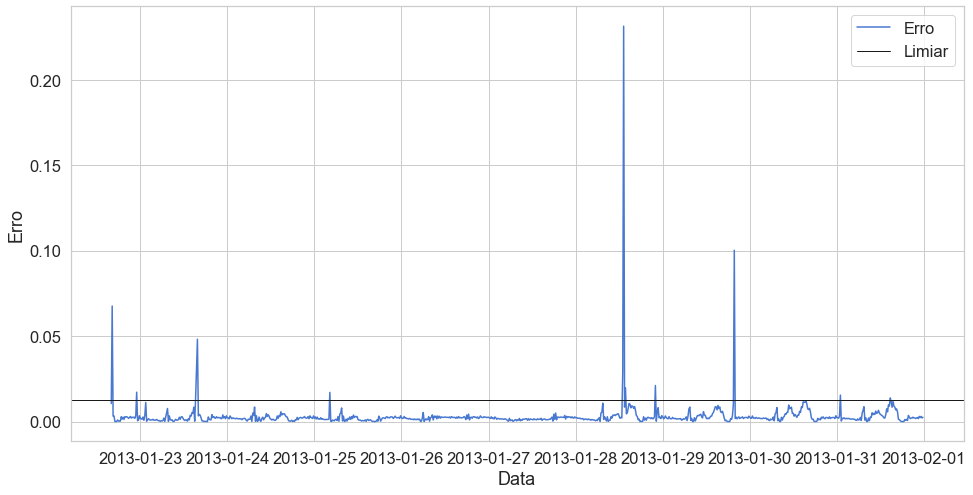

In [30]:
plt.figure(figsize=(16,8))
plt.plot (dfteste_autoencoder.index.values, dfteste_autoencoder.MSE)
plt.axhline(y=mse_threshold,linewidth=1, color='k')
plt.xlabel('Data')
plt.ylabel('Erro')
plt.legend(['Erro','Limiar','picos'])
plt.grid('on')

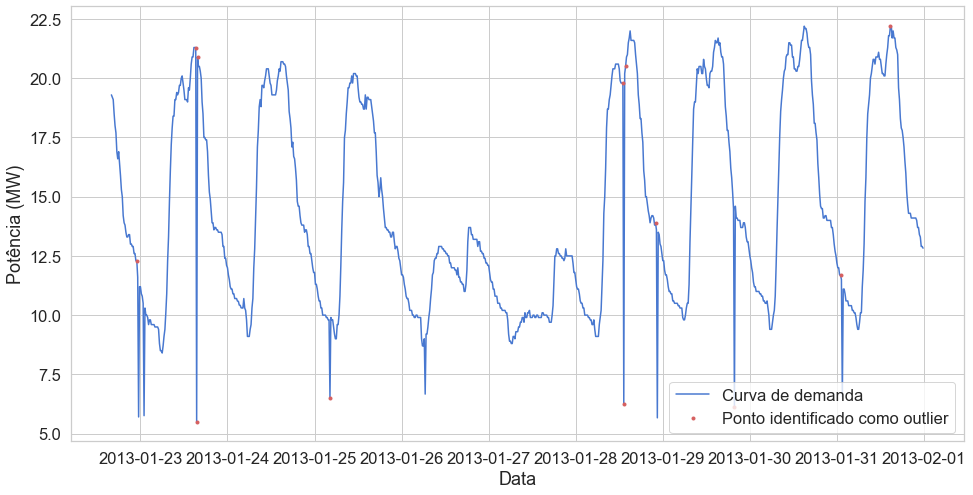

In [31]:
##PLOT RESULTADOS PREVISTOS
plt.figure(figsize=(16,8))
plt.plot (dfteste_autoencoder.index.values, dfteste_autoencoder.Potencia,outliers.index.values, outliers.Potencia,'r.')
plt.legend(['Curva de demanda','Ponto identificado como outlier'])
plt.xlabel('Data')
plt.ylabel('Potência (MW)')
#plt.legend(loc='upper left')
plt.grid('on')
plt.savefig('ex_autoencoder_outliers.pdf', bbox_inches = 'tight', pad_inches = 0)
plt.show()

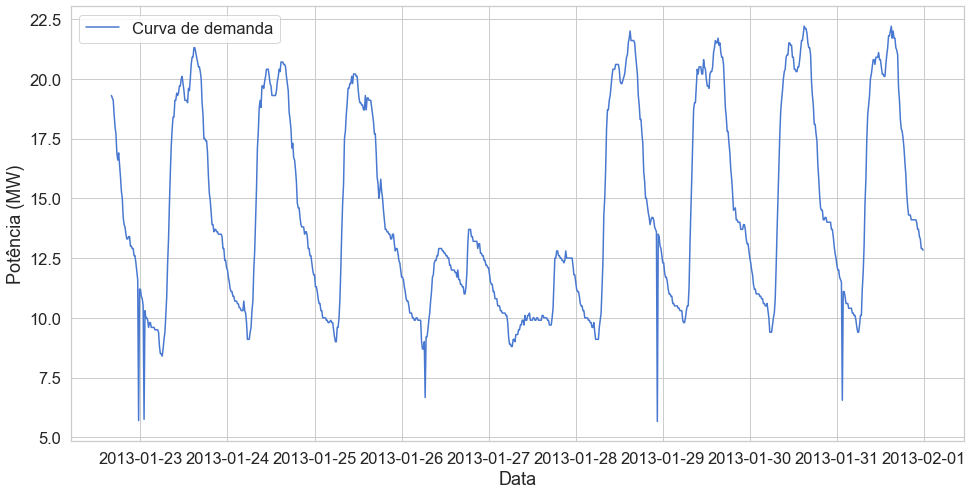

In [32]:
#Colocando todos os outliers para zeros

dfteste_autoencoder['Potencia_corrigida'] = dfteste_autoencoder.Potencia
dfteste_autoencoder.Potencia_corrigida[dfteste_autoencoder['MSE_Outlier']==1] = np.nan

#aplicar a interpolação
dfteste_autoencoder.Potencia_corrigida=dfteste_autoencoder.Potencia_corrigida.astype(float).interpolate(method='linear', limit_direction='forward', axis=0)
plt.figure(figsize=(16,8))
plt.plot (dfteste_autoencoder.index.values, dfteste_autoencoder.Potencia_corrigida)
plt.legend(['Curva de demanda'])
plt.xlabel('Data')
plt.ylabel('Potência (MW)')
plt.grid('on')
plt.savefig(f'corrigido_aut.pdf', bbox_inches = 'tight', pad_inches = 0)

              precision    recall  f1-score   support

           0       0.99      0.99      0.99       887
           1       0.33      0.44      0.38         9

    accuracy                           0.99       896
   macro avg       0.66      0.72      0.69       896
weighted avg       0.99      0.99      0.99       896



Previsto,1,All
Real,,
0,8,8
1,4,4
All,12,12


MCC = 0.37772866837188396


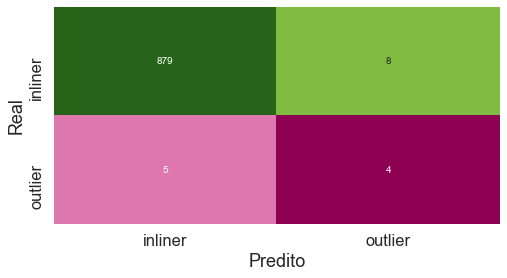

In [33]:
dfteste_autoencoder['label_aut'] = 0
dfteste_autoencoder['label_aut'][dfteste_autoencoder.is_outlier=='outlier'] = 1

##MATRIZ DE CONFUSAO
confusion_matrix = pd.crosstab(dfteste_autoencoder['label_aut'],outliers['MSE_Outlier'], rownames=['Real'], colnames=['Previsto'],  margins=True)
print(classification_report(dfteste_autoencoder['label_aut'], dfteste_autoencoder['MSE_Outlier']))
display(confusion_matrix)


from sklearn.metrics import confusion_matrix, matthews_corrcoef
print(f'MCC = {matthews_corrcoef(dfteste_autoencoder.label_aut.values,dfteste_autoencoder.MSE_Outlier.values)}')
array = confusion_matrix(dfteste_autoencoder['label_aut'],dfteste_autoencoder['MSE_Outlier'])
qtd_outlier = len(dfteste_autoencoder[dfteste_autoencoder.is_outlier=='outlier'])
df_cm = pd.DataFrame(array, index = [i for i in ["inliner","outlier"]],
              columns = [i for i in ["inliner","outlier"]])
plt.figure(figsize = (8,4))
ax = sb.heatmap(df_cm, annot=True,cmap="PiYG",fmt='d', cbar=False, vmax=qtd_outlier)
ax.set(xlabel='Predito', ylabel='Real')
plt.savefig(f"cm_aut.pdf", bbox_inches = 'tight', pad_inches = 0)
plt.show()

In [34]:
dfsemoutliers = pd.read_pickle('E:\Dropbox\PIBIC Ricado 2019\TCC Ricardo 2020-1\codigo\dados janeiro 2013\data_without_outliers.pkl')
#dfsemoutliers.set_index('Data', inplace=True)
dfsemoutliers = dfsemoutliers.tail(len(dfteste_autoencoder))

### CALC ERRO
dfteste_autoencoder.Potencia_corrigida.fillna(method='bfill', inplace=True)
from sklearn.metrics import mean_absolute_error, mean_squared_error
print(f'MAE: {mean_absolute_error(dfsemoutliers.Potencia.values, dfteste_autoencoder.Potencia_corrigida.values)}')
print(f'MSE: {mean_squared_error(dfsemoutliers.Potencia.values, dfteste_autoencoder.Potencia_corrigida.values)}')

def mean_absolute_percentage_error(y_true, y_pred): 
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

print(f'MAPE: {round(mean_absolute_percentage_error(dfsemoutliers.Potencia.values, dfteste_autoencoder.Potencia_corrigida.values),2)}%')

MAE: 0.030651782921893106
MSE: 0.1638312024203819
MAPE: 0.26%
